# Statistical forecasting on synthesized time series

* Forecasting on synthesized time series with statistical method: naive forecasting and moving average.

## Create time series with trend + seasonality + noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.sin(season_time * 2 * np.pi),
                    1 / np.exp(2 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

* Synthesized time sires with trend, seasonality, and noise

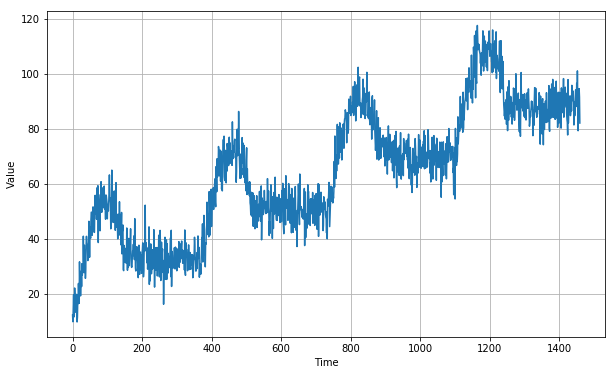

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series with trend and seasonality
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

* Split data to train and validation sets

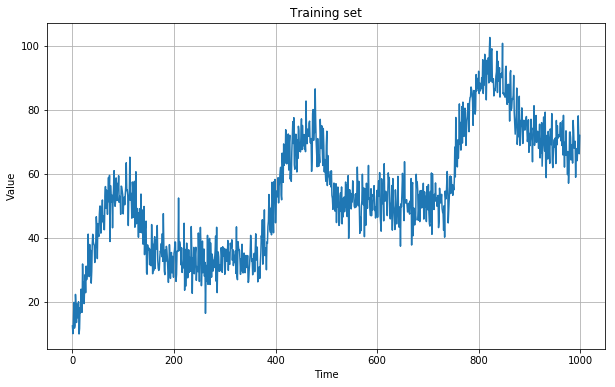

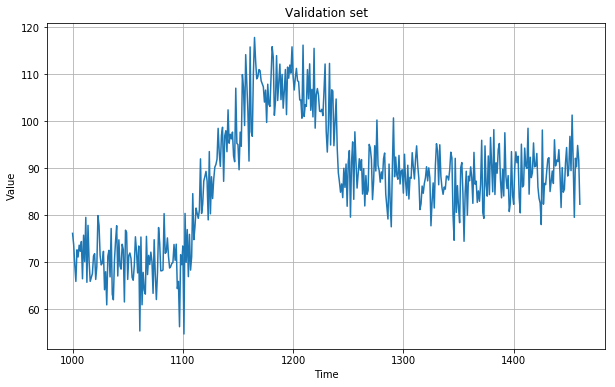

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title("Training set")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title("Validation set")
plt.show()

## Naive forecast

* Here, we use simple naive forecast method, where the value of the next time point is the same as the previous one.

In [6]:
naive_forecast = series[split_time - 1:-1]

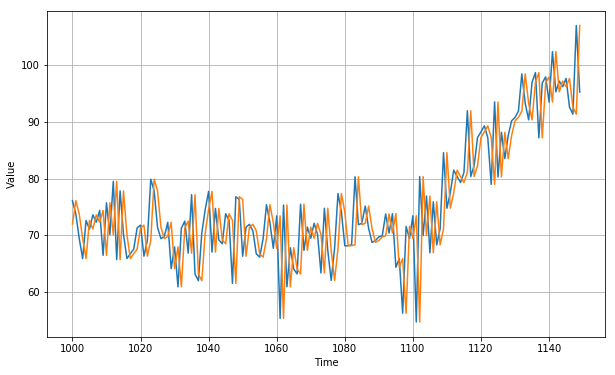

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end =150)
plot_series(time_valid, naive_forecast, start=0, end =150)
plt.show()

* Mean squre error and mean absolute error of the naive forecast

In [8]:
print("MSE = ", keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print("MAE = ", keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

MSE =  52.88058
MAE =  5.7398195


## Trailing moving average

* Here we try trailing moving average, which takes average of past values within a time window.

In [9]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

* With moving average, the line is much smoother.

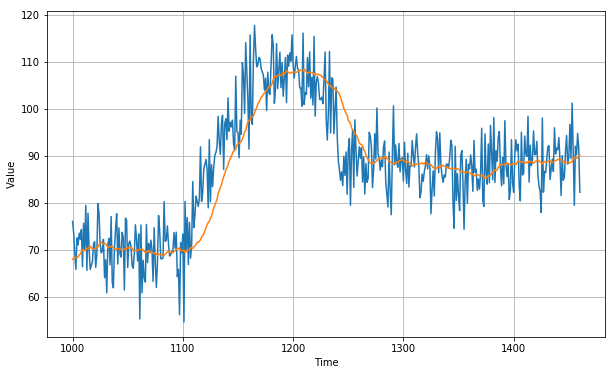

In [10]:
moving_avg = moving_average_forecast(series, 30)[split_time-30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
plt.show()

* However, the error is worse than naive forecasting.

In [11]:
print("MSE = ", keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print("MAE = ", keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

MSE =  41.977856
MAE =  5.0048404


## Trailing MA with differencing + Centered MA on past data

* Trailing MA with differencing

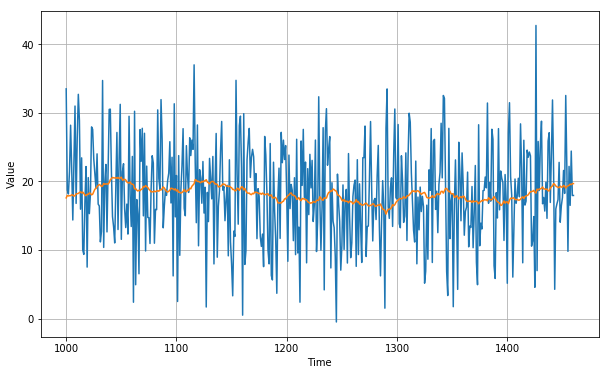

In [12]:
# Differencing
diff_series = (series[365:] - series[:-365])

# Trailing MA on differenced time series
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

* Adding the smoothed past values by centered moving average

In [13]:
# Notice that the past series used for moving average start from split_time-370 (cetered MA), 
# rather than split_time-375 (trailing).
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

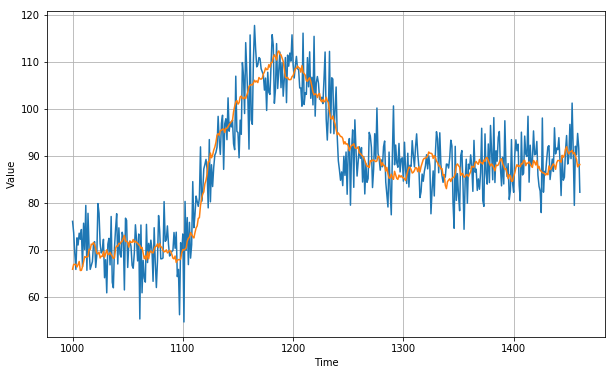

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

* Now the error is much lower than both naive and simple MA method.

In [15]:
print("MSE = ", keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print("MAE = ", keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

MSE =  29.174353
MAE =  4.348208
